# 2022 COMP5046 Assignment 1


# Readme
Marker can run Section1-3 linearly from the beginning.

For section 4 , I have summarised each sub-section in a table or diagram, followed by documentation, which can be easily accessed by clicking on Table of contents. For more information on each subsection, please scroll down. I have saved the output for each model in one cell individually.

Marker can run Section5 separately, but need to authenticate and create the PyDrive client in the first time.

# 1 - Data Preprocessing

## 1.0. Data Collection [DO NOT MODIFY THIS]

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '16g474hdNsaNx0_SnoKuqj2BuwSEGdnbt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.csv')  

id = '1-7hj0sF3Rc5G6POKdkpbDXm_Q6BWFDPU'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.csv')  

import pandas as pd
training_data = pd.read_csv("/content/training_data.csv")
testing_data = pd.read_csv("/content/testing_data.csv")

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data.iloc[-1,0], training_data.iloc[-1,1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 7808
Size of testing dataset: 867
------------------------------------
------------------------------------
Sample Data
LABEL: F / SENTENCE: 'Half of it is going straight to charity, another quarter going straight to scientific research, an eighth to the parkour community, a sixteenth to towards spreading information about health and...|||Find a path or suffer more.|||http://personalitycafe.com/enneagram-personality-theory-forum/85323-enneagram-type-mbti-type-compared-statistics.html yep.|||I kind of anchor on Fi and Ne makes having Ni really fun. INFP for me as they tire me out less and our views tend to align more.|||The two ESTPs I have gotten the chance to know seem to experience much more than other people who have been on the planet for the same amount of time and are quite the renaissance (wo)men.  Is this...|||I don't really have a best friend ISTP(passion-amateur group co-founder), INTJ(intellectual and various sma

In [ ]:
# Preview of the data in the csv file, which has two columns: 
# (1)type - label of the post (2)posts - the corresponding post content
training_data.head()

,type,posts
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,T,'I'm finding the lack of me in these posts ver...
2,T,'Good one _____ https://www.youtube.com/wat...
3,T,"'Dear INTP, I enjoyed our conversation the o..."
4,T,'You're fired.|||That's another silly misconce...


In [ ]:
# Extract the labels and posts and store into List

# Get the list of training data (posts)
training_posts=training_data['posts'].tolist()
# Get the list of corresponding labels for the training data (posts)
training_labels=training_data['type'].tolist()

# Get the list of testing data (posts)
testing_posts=testing_data['posts'].tolist()
# Get the list of corresponding labels for the testing data (posts)
testing_labels=testing_data['type'].tolist()

## 1.1. URL Removal
*related to the section 4.2*

In [ ]:
import re
def remove_urls(text):
    URLS_REGEX = re.compile(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', 
        re.IGNORECASE) #reference: https://stackoverflow.com/questions/4390556/extract-url-from-string
    text = re.sub(URLS_REGEX, '', text)
    return text

## 1.2. Preprocess data (e.g. Stop words, Stemming)
*related to the section 4.2*

In [ ]:
import numpy as np
import nltk
#Stopword
import string
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stopwords=sw.words('english')
#Tokenisation + Lowercase
from nltk.tokenize import TweetTokenizer #TweetTokenizer can retain Emoticons
tknzr = TweetTokenizer(preserve_case= False) #preserve_case= False->the tokenizer will downcase everything except for Emoticons
#Stemming
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')
#Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_data(text, url=True, mode=None):
    preprocessed_posts=[ ]
    for post in text :
        if url == True:
            post=remove_urls(post)
        remove_num = re.sub(r'[0-9]',' ', post) #Remove number
        remove_punc = re.sub(r'\.\.+|\||#|@', ' ', remove_num) #Remove a few common punctuations (to retain Emoticons in Tokenisation)
        clean_post = re.sub(r"\s+.\s", " ", remove_punc) #Remove signal characters
        tokenized_post = tknzr.tokenize(clean_post) #Tokenisation +Lowercase(except Emoticons)
        tokenized_post =  [w for w in tokenized_post if not w in stopwords and len(w)>1]
        if mode == 'stem':
            tokenized_post = [snowball_stemmer.stem(w) for w in tokenized_post]
        elif mode =='lemm':
            tokenized_post = [lemmatizer.lemmatize(w) for w in tokenized_post]
        else:
            tokenized_post = tokenized_post
        preprocessed_posts.append(tokenized_post)
    return preprocessed_posts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
training_preprocessed_posts = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts = training_preprocessed_posts+testing_preprocessed_posts

# 2 - Input Representation


## 2.1. Word Embedding Construction
*related to the section 4.1 and 4.3*


In [ ]:
#Get Word List
def construct_wordlist_and_worddict(all_preprocessed_posts):
    word_set = set() 
    for post in all_preprocessed_posts:
        for word in post:
            word_set.add(word)
    word_set.add('[PAD]')
    word_set.add('[UNKNOWN]')

    word_list = list(word_set) 
    word_list.sort()
    #Get Word Dict
    word_dict = {}
    ind = 0
    for word in word_list:
        word_dict[word] = ind
        ind += 1
    return word_list, word_dict

In [ ]:
word_list, word_dict = construct_wordlist_and_worddict(all_preprocessed_posts)

In [ ]:
##To store word dictionary
# import pickle
# with open('word_dict.pkl','wb') as f:
#   pickle.dump(word_dict, f)

In [ ]:
def encode_and_add_padding(posts, word_index):
    post_encoded = []
    post_length = 600
    for post in posts:
        if not len(post) > post_length:
            temp_encoded = [word_index[word] if word in word_index  #If the word is in word_dict, return the corresponding value
                            else word_index['[UNKNOWN]'] #If the word is not in word_dict, then the value corresponding to [UNKNOWN] is returned
                            for word in post] 
            if len(temp_encoded) < post_length: #If shorter than the predetermined length, the value of [PAD] will be added
                temp_encoded += [word_index['[PAD]']] * (post_length - len(temp_encoded))
        else:
            post = post[ :post_length]
            temp_encoded = [word_index[word] if word in word_index 
                            else word_index['[UNKNOWN]'] 
                            for word in post]
        post_encoded.append(temp_encoded)
    return post_encoded 

In [ ]:
training_posts_encoded = encode_and_add_padding(training_preprocessed_posts, word_dict)
testing_posts_encoded= encode_and_add_padding(testing_preprocessed_posts, word_dict)



---



In [ ]:
from gensim.models import Word2Vec
wv_cbow_model = Word2Vec(sentences=all_preprocessed_posts, size=50, window=6, min_count=3, workers=2, sg=0)

In [ ]:
def construct_trained_word_embedding(list_of_words, word_emb_model ):
    emb_table=[]
    emb_dim = word_emb_model.vector_size
    for i, word in enumerate(list_of_words):
        if word in word_emb_model:
            emb_table.append(word_emb_model[word]) #Copy the vector corresponding to word_list from trained embedding into emb_table
        else:
            emb_table.append([0]*emb_dim)
    emb_table = np.array(emb_table)
    return emb_table

In [ ]:
trained_emb_table = construct_trained_word_embedding(word_list, wv_cbow_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## 2.2. Pretrained Word Embedding
*related to the section 4.3*

In [ ]:
import gensim.downloader as api 
def counstruct_pretrained_word_embedding(list_of_words, model_type='gt_100'):
    if model_type == 'gt_25':
        word_emb_model = api.load("glove-twitter-25")
    else:
        word_emb_model = api.load("glove-twitter-100")
    emb_dim = word_emb_model.vector_size
    emb_table=[]
    for i, word in enumerate(list_of_words):
        if word in word_emb_model:
            emb_table.append(word_emb_model[word])
        else:
            # The pretrained glove twitter may not contain the embeddings that exists in word_list, so add zero vectors.
            emb_table.append([0]*emb_dim)
    emb_table = np.array(emb_table) 
    return emb_table

In [ ]:
pretrained_emb_table = counstruct_pretrained_word_embedding(word_list, model_type='gt_100')

[==================================================] 100.0% 387.1/387.1MB downloaded


## 2.3. Input Concatenation
*related to the section 4.3*

In [ ]:
def input_concatenation(trained_word_emb, pretrained_word_emb):
    emb_table_con = np.hstack((trained_word_emb, pretrained_word_emb))
    return emb_table_con

In [ ]:
emb_table_con = input_concatenation(trained_emb_table, pretrained_emb_table)

# 3 - Model Implementation

### 3.1. Build Sequence Model (Bi-directional model)
*related to the section 4.4*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)
# print(unique_labels)
# print(lEnc.transform(unique_labels))
# ['F' 'T']
# [0 1]

vocab_size = len(word_list)
emb_table = emb_table_con
emb_dim = emb_table_con.shape[-1]
n_hidden = 16 

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

In [ ]:
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

### 3.2. Train Sequence Model (Bi-directional model)

*related to the section 4.4*

Note that it will not be marked if you do not display the Training Loss and the Number of Epochs in the Assignment 1 ipynb.


In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_data = TensorDataset(torch.Tensor(training_posts_encoded), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [ ]:
model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6838	Train_acc: 55.64%	
Epoch: 02 ->	Train_loss: 0.6265	Train_acc: 64.38%	
Epoch: 03 ->	Train_loss: 0.5828	Train_acc: 68.93%	
Epoch: 04 ->	Train_loss: 0.5930	Train_acc: 68.19%	
Epoch: 05 ->	Train_loss: 0.5540	Train_acc: 71.84%	
Epoch: 06 ->	Train_loss: 0.4944	Train_acc: 76.65%	
Epoch: 07 ->	Train_loss: 0.4021	Train_acc: 82.17%	
Epoch: 08 ->	Train_loss: 0.3298	Train_acc: 85.98%	
Epoch: 09 ->	Train_loss: 0.2853	Train_acc: 88.13%	
Epoch: 10 ->	Train_loss: 0.2443	Train_acc: 90.30%	
--------------------Training Finish---------------------


In [ ]:
##To save best model.
#torch.save(model, 'best_model.pt')

In [ ]:
input_torch = torch.from_numpy(np.array(testing_posts_encoded)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report
print(classification_report(testing_labels_encoded, predicted.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       467
           1       0.81      0.75      0.78       400

    accuracy                           0.80       867
   macro avg       0.80      0.80      0.80       867
weighted avg       0.80      0.80      0.80       867



# 4 - Evaluation


## 4.1. Word Embedding Evaluation
You are to apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.
Note that it will not be marked if you do not display it in the ipynb file.


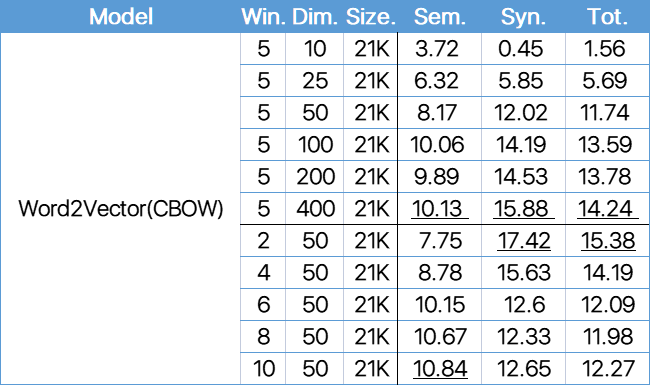

**Answer: (The line chart is shown in the output below)**

**The Word2Vector (CBOW) model is used for this vector dimension comparison experiment. As the vector dimension increases, all three accuracy rates increase. However, after the vector dimension reaches 50, the trend of increasing accuracy gradually decreases. This phenomenon suggests that increasing the vector dimension appropriately allows the model to learn the semantic information and syntactic information of the input data better. Although there is a small increase in accuracy at 100 dimensions, the optimal parameter for this experiment is set at 50, considering the computational efficiency.** 

**The Word2Vector (CBOW) model is used for window size comparison experiment. When the window size is small (i.e. 2), the semantic accuracy is much lower than both syntactic and overall, to the extent that a huge gap is formed. as the window size gradually increases, the gap between them is gradually decreasing. When the window size is larger than 6, their accuracies both tend to level off. This phenomenon suggests that when the window size is set too small (i.e. too few context words), the model does not capture the semantic information of the input data very well. As the window increases, there may be more than two kinds of sentences covered in the window, which will reduce the syntactic accuracy of the model. Based on the comprehensive performance, the best window size can been seen as 6.**



In [ ]:
def construct_normalized_vector(list_of_words, word_emb_model):
    vectors_dict= {}
    for word in list_of_words:
        if word in word_emb_model:
            vector = word_emb_model.wv[word]
            vectors_dict[word] = [float(x) for x in vector]
        else:
            continue

    vocab_words=list(vectors_dict.keys())
    vocab_size = len(vocab_words)
    #print("Vocab size: ",str(vocab_size))
    vocab = {w: idx for idx, w in enumerate(vocab_words)}
    ivocab = {idx: w for idx, w in enumerate(vocab_words)}

    vector_dim = len(vectors_dict[ivocab[0]])
    W = np.zeros((vocab_size, vector_dim))
    for word, v in vectors_dict.items():
        if word == '<unk>':
            continue
        W[vocab[word], :] = v

    W_norm = np.zeros(W.shape)
    d = (np.sum(W ** 2, 1) ** (0.5))
    W_norm = (W.T / d).T
    return W_norm, vocab

def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            # print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            # print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)

            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()
      
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

fatal: destination path 'GloVe' already exists and is not an empty directory.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.


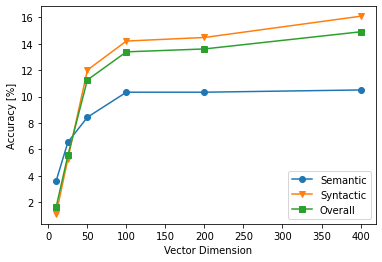

In [ ]:
!git clone https://github.com/stanfordnlp/GloVe.git

from gensim.models import Word2Vec
import matplotlib.pyplot as plt

sem_acc_recorder=[]
syn_acc_recorder=[]
tol_acc_recorder=[]
dimensions=[10, 25, 50, 100, 200, 400]
for size in dimensions:
    wv_cbow_model = Word2Vec(sentences=all_preprocessed_posts, size=size, window=5, min_count=3, workers=2, sg=0)
    W_norm, vocab = construct_normalized_vector(word_list, wv_cbow_model)
    correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, _ = evaluate_vectors(W_norm, vocab,  prefix='/content/GloVe/eval/question-data')
    sem_acc = correct_sem / float(count_sem)
    sem_acc_recorder.append(sem_acc)
    
    syn_acc = correct_syn / float(count_syn)
    syn_acc_recorder.append(syn_acc)

    tol_acc =  correct_tot / float(count_tot)   
    tol_acc_recorder.append(tol_acc)


semantic_accurarcy = np.array(sem_acc_recorder)
semantic_accurarcy = np.round(semantic_accurarcy*100, 2)

syntactic_accurarcy = np.array(syn_acc_recorder)
syntactic_accurarcy = np.round(syntactic_accurarcy*100, 2)

toltal_accurarcy = np.array(tol_acc_recorder)
toltal_accurarcy = np.round(toltal_accurarcy*100, 2)

plt.plot(dimensions, semantic_accurarcy, label = 'Semantic', marker='o')
plt.plot(dimensions, syntactic_accurarcy, label = 'Syntactic', marker='v')
plt.plot(dimensions, toltal_accurarcy, label = 'Overall', marker='s')

plt.xlabel('Vector Dimension')
plt.ylabel('Accuracy [%]')
plt.legend()

plt.show()



---



fatal: destination path 'GloVe' already exists and is not an empty directory.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.


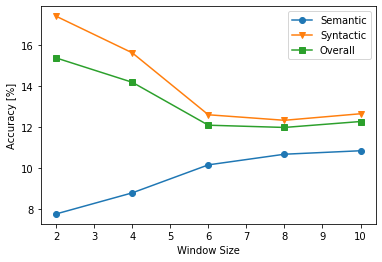

In [ ]:
!git clone https://github.com/stanfordnlp/GloVe.git

from gensim.models import Word2Vec
import matplotlib.pyplot as plt

sem_acc_recorder=[]
syn_acc_recorder=[]
tol_acc_recorder=[]
windows=[2 ,4 ,6, 8, 10]
for window in windows:
    wv_cbow_model = Word2Vec(sentences=all_preprocessed_posts, size=50, window=window, min_count=3, workers=2, sg=0)
    W_norm, vocab = construct_normalized_vector(word_list, wv_cbow_model)
    correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, _ = evaluate_vectors(W_norm, vocab,  prefix='/content/GloVe/eval/question-data')
    sem_acc = correct_sem / float(count_sem)
    sem_acc_recorder.append(sem_acc)
    
    syn_acc = correct_syn / float(count_syn)
    syn_acc_recorder.append(syn_acc)

    tol_acc =  correct_tot / float(count_tot)   
    tol_acc_recorder.append(tol_acc)


semantic_accurarcy = np.array(sem_acc_recorder)
semantic_accurarcy = np.round(semantic_accurarcy*100, 2)

syntactic_accurarcy = np.array(syn_acc_recorder)
syntactic_accurarcy = np.round(syntactic_accurarcy*100, 2)

toltal_accurarcy = np.array(tol_acc_recorder)
toltal_accurarcy = np.round(toltal_accurarcy*100, 2)

plt.plot(windows, semantic_accurarcy, label = 'Semantic', marker='o')
plt.plot(windows, syntactic_accurarcy, label = 'Syntactic', marker='v')
plt.plot(windows, toltal_accurarcy, label = 'Overall', marker='s')

plt.xlabel('Window Size')
plt.ylabel('Accuracy [%]')
plt.legend()

plt.show()

## 4.2. Performance Evaluation with Data Processing Techiques


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


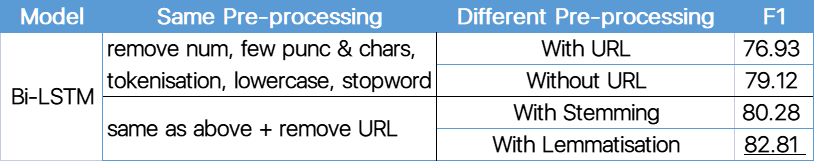

**Answer: (The test information for each model is shown in the output below)**

**In this comparison experiment for data preprocessing, the Bi-LSTM model is used. The word embedding is constructed by the Word2Vector model, and the pre-trained word embedding is glove-twitter-25.**

**It can be seen from the F1 sorce that the data with URLs is lower than the data without URLs in terms of test set accuracy. This proves that the URL affects the classification of the input data by the model to some extent. However, the main reason for the small difference in accuracy between the two is that TweetTokenizer is used as a word splitting tool. TweetTokenizer makes a very reasonable division of URLs, emoticons, etc. Also, since the parameter min_count=3 in  Word2Vector model, so that most URLs are set to zero vector.**

**As for the comparison of the other two pre-processing methods, they differ in that one uses the Stemming method and the other uses the Lemmatisation method. Stemming is a simple lightweight morphological subsumption method and the final result is a word stem, while lemmatisation is a more complex process that results in a word prototype and is therefore more lexicon-dependent. Compared with the methods above , they only have a small increase in accuracy. This suggests that both methods are less effective for this dataset, most likely due to the fact that the same pre-processing has already played a large role. Ultimately, the optimal preprocessing method for this experiment was to remove URLs combined with Lemmatisation.**


In [ ]:
training_preprocessed_posts1 = preprocess_data(training_posts, url=False, mode=None)
testing_preprocessed_posts1 = preprocess_data(testing_posts, url =False, mode=None)
all_preprocessed_posts1 = training_preprocessed_posts1+testing_preprocessed_posts1

word_list1, word_dict1 = construct_wordlist_and_worddict(all_preprocessed_posts1)
training_posts_encoded1 = encode_and_add_padding(training_preprocessed_posts1, word_dict1)
testing_posts_encoded1 = encode_and_add_padding(testing_preprocessed_posts1, word_dict1)
from gensim.models import Word2Vec
wv_cbow_model1 = Word2Vec(sentences=all_preprocessed_posts1, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table1 = construct_trained_word_embedding(word_list1, wv_cbow_model1)
pretrained_emb_table1 = counstruct_pretrained_word_embedding(word_list1, model_type='gt_25')
emb_table_con1 = input_concatenation(trained_emb_table1, pretrained_emb_table1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list1) 
emb_table = emb_table_con1
emb_dim = emb_table_con1.shape[-1
n_hidden =  16

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded1), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>>>>>>>Bi-LSTM With URL<<<<<<<<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded1)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6799	Train_acc: 57.10%	
Epoch: 02 ->	Train_loss: 0.6135	Train_acc: 66.16%	
Epoch: 03 ->	Train_loss: 0.5796	Train_acc: 69.34%	
Epoch: 04 ->	Train_loss: 0.5097	Train_acc: 75.17%	
Epoch: 05 ->	Train_loss: 0.4566	Train_acc: 78.94%	
Epoch: 06 ->	Train_loss: 0.4207	Train_acc: 81.20%	
Epoch: 07 ->	Train_loss: 0.3995	Train_acc: 82.65%	
Epoch: 08 ->	Train_loss: 0.3772	Train_acc: 83.80%	
Epoch: 09 ->	Train_loss: 0.3519	Train_acc: 84.66%	
Epoch: 10 ->	Train_loss: 0.3330	Train_acc: 85.92%	
--------------------Training Finish---------------------

>>>>>>>>>>Bi-LSTM With URL<<<<<<<<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.79      0.77      0.78       467
           T       0.74      0.77      0.75       400

    accuracy                           0.77       867
   macro avg       0.77      0.77      0.77       867
weighted a

,Predicted Negative,Predicted Positive
Actual Negative,361,106
Actual Positive,94,306




---



In [ ]:
training_preprocessed_posts2 = preprocess_data(training_posts, url=True, mode=None)
testing_preprocessed_posts2 = preprocess_data(testing_posts, url =True, mode=None)
all_preprocessed_posts2 = training_preprocessed_posts2+testing_preprocessed_posts2

word_list2, word_dict2 = construct_wordlist_and_worddict(all_preprocessed_posts2)
training_posts_encoded2 = encode_and_add_padding(training_preprocessed_posts2, word_dict2)
testing_posts_encoded2 = encode_and_add_padding(testing_preprocessed_posts2, word_dict2)
from gensim.models import Word2Vec
wv_cbow_model2 = Word2Vec(sentences=all_preprocessed_posts2, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table2 = construct_trained_word_embedding(word_list2, wv_cbow_model2)
pretrained_emb_table2 = counstruct_pretrained_word_embedding(word_list2, model_type='gt_25')
emb_table_con2 = input_concatenation(trained_emb_table2, pretrained_emb_table2)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list2) 
emb_table = emb_table_con2
emb_dim = emb_table_con2.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded2), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>>>>>>Bi-LSTM Without URL<<<<<<<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded2)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6793	Train_acc: 56.48%	
Epoch: 02 ->	Train_loss: 0.6164	Train_acc: 66.85%	
Epoch: 03 ->	Train_loss: 0.6041	Train_acc: 67.23%	
Epoch: 04 ->	Train_loss: 0.4990	Train_acc: 76.55%	
Epoch: 05 ->	Train_loss: 0.4381	Train_acc: 80.76%	
Epoch: 06 ->	Train_loss: 0.4174	Train_acc: 81.63%	
Epoch: 07 ->	Train_loss: 0.3746	Train_acc: 84.22%	
Epoch: 08 ->	Train_loss: 0.3518	Train_acc: 85.05%	
Epoch: 09 ->	Train_loss: 0.3218	Train_acc: 86.57%	
Epoch: 10 ->	Train_loss: 0.2983	Train_acc: 87.78%	
--------------------Training Finish---------------------

>>>>>>>>>Bi-LSTM Without URL<<<<<<<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.83      0.77      0.80       467
           T       0.75      0.82      0.78       400

    accuracy                           0.79       867
   macro avg       0.79      0.79      0.79       867
weighted 

,Predicted Negative,Predicted Positive
Actual Negative,358,109
Actual Positive,72,328




---



In [ ]:
training_preprocessed_posts3 = preprocess_data(training_posts, url=True, mode='stem')
testing_preprocessed_posts3 = preprocess_data(testing_posts, url=True, mode='stem')
all_preprocessed_posts3 = training_preprocessed_posts3+testing_preprocessed_posts3

word_list3, word_dict3 = construct_wordlist_and_worddict(all_preprocessed_posts3)
training_posts_encoded3 = encode_and_add_padding(training_preprocessed_posts3, word_dict3)
testing_posts_encoded3 = encode_and_add_padding(testing_preprocessed_posts3, word_dict3)
from gensim.models import Word2Vec
wv_cbow_model3 = Word2Vec(sentences=all_preprocessed_posts3, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table3 = construct_trained_word_embedding(word_list3, wv_cbow_model3)
pretrained_emb_table3 = counstruct_pretrained_word_embedding(word_list3, model_type='gt_25')
emb_table_con3 = input_concatenation(trained_emb_table3, pretrained_emb_table3)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list3) 
emb_table = emb_table_con3
emb_dim = emb_table_con3.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded3), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>Bi-LSTM With Stemming(w/o Lemmatisation)<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded3)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6821	Train_acc: 56.05%	
Epoch: 02 ->	Train_loss: 0.6238	Train_acc: 65.20%	
Epoch: 03 ->	Train_loss: 0.5374	Train_acc: 74.08%	
Epoch: 04 ->	Train_loss: 0.5957	Train_acc: 68.31%	
Epoch: 05 ->	Train_loss: 0.5510	Train_acc: 72.43%	
Epoch: 06 ->	Train_loss: 0.4850	Train_acc: 78.21%	
Epoch: 07 ->	Train_loss: 0.4421	Train_acc: 81.07%	
Epoch: 08 ->	Train_loss: 0.4559	Train_acc: 78.94%	
Epoch: 09 ->	Train_loss: 0.4059	Train_acc: 82.66%	
Epoch: 10 ->	Train_loss: 0.3726	Train_acc: 84.63%	
--------------------Training Finish---------------------

>>Bi-LSTM With Stemming(w/o Lemmatisation)<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.83      0.80      0.81       467
           T       0.78      0.80      0.79       400

    accuracy                           0.80       867
   macro avg       0.80      0.80      0.80       867
wei

,Predicted Negative,Predicted Positive
Actual Negative,375,92
Actual Positive,79,321




---



In [ ]:
training_preprocessed_posts4 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts4 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts4 = training_preprocessed_posts4+testing_preprocessed_posts4

word_list4, word_dict4 = construct_wordlist_and_worddict(all_preprocessed_posts4)
training_posts_encoded4 = encode_and_add_padding(training_preprocessed_posts4, word_dict4)
testing_posts_encoded4 = encode_and_add_padding(testing_preprocessed_posts4, word_dict4)
from gensim.models import Word2Vec
wv_cbow_model4 = Word2Vec(sentences=all_preprocessed_posts4, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table4 = construct_trained_word_embedding(word_list4, wv_cbow_model4)
pretrained_emb_table4 = counstruct_pretrained_word_embedding(word_list4, model_type='gt_25')
emb_table_con4 = input_concatenation(trained_emb_table4, pretrained_emb_table4)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list4) 
emb_table = emb_table_con4
emb_dim = emb_table_con4.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded4), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>Bi-LSTM With Lemmatisation(w/o Stemming)<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded4)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6819	Train_acc: 56.03%	
Epoch: 02 ->	Train_loss: 0.6311	Train_acc: 64.60%	
Epoch: 03 ->	Train_loss: 0.6281	Train_acc: 64.79%	
Epoch: 04 ->	Train_loss: 0.5624	Train_acc: 71.45%	
Epoch: 05 ->	Train_loss: 0.4942	Train_acc: 77.41%	
Epoch: 06 ->	Train_loss: 0.5467	Train_acc: 71.22%	
Epoch: 07 ->	Train_loss: 0.4632	Train_acc: 79.57%	
Epoch: 08 ->	Train_loss: 0.3907	Train_acc: 83.57%	
Epoch: 09 ->	Train_loss: 0.3821	Train_acc: 83.86%	
Epoch: 10 ->	Train_loss: 0.3600	Train_acc: 84.86%	
--------------------Training Finish---------------------

>>Bi-LSTM With Lemmatisation(w/o Stemming)<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.79      0.92      0.85       467
           T       0.88      0.72      0.80       400

    accuracy                           0.83       867
   macro avg       0.84      0.82      0.82       867
wei

,Predicted Negative,Predicted Positive
Actual Negative,429,38
Actual Positive,111,289




---



## 4.3. Performance Evaluation with Different Input


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


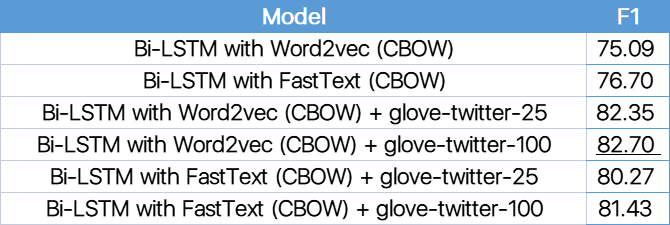

**Answer: (The test information for each model is shown in the output below)**


**A total of six different models are constructed for this experiment. As can be seen from the figure, the first two models doesn't add pre-trained word embeddings and the test set accuracy is around 75% (>50%). The final results are more satisfactory due to the small amount of data in the test set and the fact that the data had been pre-processed. Although the first two models use different word embedding methods, the difference between them is not significant. FastText breaks words into several n-grams (sub-words) so it can handle the Out-of-Vocabulary. Thus, its accuracy is slightly higher.**

**As for the latter four models, pre-trained word embeddings with different dimensions are added, which increases the accuracy of the test set to some extent. It is worth noting that this experiment is a sentiment analysis problem, so the glove-twitter pre-trained word embedding is chosen. Since Tweets are very similar to the experimental data (Posts), this word embedding can better represent some web phrases or emoticons. In addition, as the number of dimensions of the pre-trained word vector increases, the accuracy of the test set increases slightly. This is because the higher the dimensionality of the word embeddings, the better they describe the correlation or difference between words, but the negative effect is a significant increase in computational cost. Finally, based on the optimal results, glove-twitter-100 pre-trained word embeddings are selected and combined with Word2Vec (CBOW) as the concatnated word embeddings for the optimal model.**



In [ ]:
training_preprocessed_posts5 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts5 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts5 = training_preprocessed_posts5+testing_preprocessed_posts5

word_list5, word_dict5 = construct_wordlist_and_worddict(all_preprocessed_posts5)
training_posts_encoded5 = encode_and_add_padding(training_preprocessed_posts5, word_dict5)
testing_posts_encoded5 = encode_and_add_padding(testing_preprocessed_posts5, word_dict5)
from gensim.models import Word2Vec
wv_cbow_model5 = Word2Vec(sentences=all_preprocessed_posts5, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table5 = construct_trained_word_embedding(word_list5, wv_cbow_model5)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list5) 
emb_table = trained_emb_table5
emb_dim = trained_emb_table5.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded5), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>>>Bi-LSTM with Word2vec (CBOW)<<<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded5)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6787	Train_acc: 56.76%	
Epoch: 02 ->	Train_loss: 0.6300	Train_acc: 64.70%	
Epoch: 03 ->	Train_loss: 0.5748	Train_acc: 70.89%	
Epoch: 04 ->	Train_loss: 0.5613	Train_acc: 71.00%	
Epoch: 05 ->	Train_loss: 0.5870	Train_acc: 69.86%	
Epoch: 06 ->	Train_loss: 0.5648	Train_acc: 70.22%	
Epoch: 07 ->	Train_loss: 0.5093	Train_acc: 75.68%	
Epoch: 08 ->	Train_loss: 0.4752	Train_acc: 77.19%	
Epoch: 09 ->	Train_loss: 0.4388	Train_acc: 80.08%	
Epoch: 10 ->	Train_loss: 0.4196	Train_acc: 81.53%	
--------------------Training Finish---------------------

>>>>>>Bi-LSTM with Word2vec (CBOW)<<<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.82      0.69      0.75       467
           T       0.69      0.82      0.75       400

    accuracy                           0.75       867
   macro avg       0.76      0.76      0.75       867
weighte

,Predicted Negative,Predicted Positive
Actual Negative,322,145
Actual Positive,71,329




---



In [ ]:
training_preprocessed_posts6 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts6 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts6 = training_preprocessed_posts6+testing_preprocessed_posts6

word_list6, word_dict6 = construct_wordlist_and_worddict(all_preprocessed_posts6)
training_posts_encoded6 = encode_and_add_padding(training_preprocessed_posts6, word_dict6)
testing_posts_encoded6 = encode_and_add_padding(testing_preprocessed_posts6, word_dict6)
from gensim.models import FastText
ft_sg_model6 = FastText(sentences =all_preprocessed_posts6, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table6 = construct_trained_word_embedding(word_list6, ft_sg_model6)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list6) 
emb_table = trained_emb_table6
emb_dim = trained_emb_table6.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded6), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>>>>Bi-LSTM with FastText (CBOW)<<<<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded6)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6828	Train_acc: 55.81%	
Epoch: 02 ->	Train_loss: 0.6418	Train_acc: 62.81%	
Epoch: 03 ->	Train_loss: 0.5879	Train_acc: 69.17%	
Epoch: 04 ->	Train_loss: 0.6556	Train_acc: 60.75%	
Epoch: 05 ->	Train_loss: 0.6058	Train_acc: 65.43%	
Epoch: 06 ->	Train_loss: 0.5618	Train_acc: 70.18%	
Epoch: 07 ->	Train_loss: 0.6124	Train_acc: 65.68%	
Epoch: 08 ->	Train_loss: 0.6019	Train_acc: 67.01%	
Epoch: 09 ->	Train_loss: 0.4993	Train_acc: 76.42%	
Epoch: 10 ->	Train_loss: 0.4594	Train_acc: 79.43%	
--------------------Training Finish---------------------

>>>>>>>Bi-LSTM with FastText (CBOW)<<<<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.81      0.75      0.78       467
           T       0.73      0.79      0.76       400

    accuracy                           0.77       867
   macro avg       0.77      0.77      0.77       867
weigh

,Predicted Negative,Predicted Positive
Actual Negative,349,118
Actual Positive,84,316




---



In [ ]:
training_preprocessed_posts7 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts7 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts7 = training_preprocessed_posts7+testing_preprocessed_posts7

word_list7, word_dict7 = construct_wordlist_and_worddict(all_preprocessed_posts7)
training_posts_encoded7 = encode_and_add_padding(training_preprocessed_posts7, word_dict7)
testing_posts_encoded7 = encode_and_add_padding(testing_preprocessed_posts7, word_dict7)
from gensim.models import Word2Vec
wv_cbow_model7 = Word2Vec(sentences=all_preprocessed_posts7, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table7 = construct_trained_word_embedding(word_list7, wv_cbow_model7)
pretrained_emb_table7 = counstruct_pretrained_word_embedding(word_list7, model_type='gt_25')
emb_table_con7 = input_concatenation(trained_emb_table7, pretrained_emb_table7)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list7) 
emb_table = emb_table_con7
emb_dim = emb_table_con7.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded7), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>Bi-LSTM with Word2vec (CBOW) + gt_25<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded7)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6799	Train_acc: 55.96%	
Epoch: 02 ->	Train_loss: 0.6122	Train_acc: 67.21%	
Epoch: 03 ->	Train_loss: 0.5747	Train_acc: 70.94%	
Epoch: 04 ->	Train_loss: 0.5469	Train_acc: 71.73%	
Epoch: 05 ->	Train_loss: 0.4780	Train_acc: 78.33%	
Epoch: 06 ->	Train_loss: 0.4013	Train_acc: 83.16%	
Epoch: 07 ->	Train_loss: 0.3596	Train_acc: 85.23%	
Epoch: 08 ->	Train_loss: 0.3297	Train_acc: 86.26%	
Epoch: 09 ->	Train_loss: 0.3041	Train_acc: 87.41%	
Epoch: 10 ->	Train_loss: 0.2737	Train_acc: 88.88%	
--------------------Training Finish---------------------

>>>Bi-LSTM with Word2vec (CBOW) + gt_25<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.82      0.85      0.84       467
           T       0.82      0.79      0.80       400

    accuracy                           0.82       867
   macro avg       0.82      0.82      0.82       867
weig

,Predicted Negative,Predicted Positive
Actual Negative,399,68
Actual Positive,85,315




---



In [ ]:
training_preprocessed_posts8 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts8 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts8 = training_preprocessed_posts8+testing_preprocessed_posts8

word_list8, word_dict8 = construct_wordlist_and_worddict(all_preprocessed_posts8)
training_posts_encoded8 = encode_and_add_padding(training_preprocessed_posts8, word_dict8)
testing_posts_encoded8 = encode_and_add_padding(testing_preprocessed_posts8, word_dict8)
from gensim.models import FastText
ft_sg_model8 = FastText(sentences =all_preprocessed_posts8, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table8 = construct_trained_word_embedding(word_list8, ft_sg_model8)
pretrained_emb_table8 = counstruct_pretrained_word_embedding(word_list8, model_type='gt_25')
emb_table_con8 = input_concatenation(trained_emb_table8, pretrained_emb_table8)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list8) 
emb_table = emb_table_con8
emb_dim = emb_table_con8.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded8), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>Bi-LSTM with FastText (CBOW) + gt_25<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded8)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6853	Train_acc: 54.76%	
Epoch: 02 ->	Train_loss: 0.6530	Train_acc: 61.40%	
Epoch: 03 ->	Train_loss: 0.5707	Train_acc: 70.93%	
Epoch: 04 ->	Train_loss: 0.5301	Train_acc: 73.57%	
Epoch: 05 ->	Train_loss: 0.5049	Train_acc: 77.10%	
Epoch: 06 ->	Train_loss: 0.5321	Train_acc: 73.86%	
Epoch: 07 ->	Train_loss: 0.4536	Train_acc: 79.37%	
Epoch: 08 ->	Train_loss: 0.3944	Train_acc: 82.57%	
Epoch: 09 ->	Train_loss: 0.3796	Train_acc: 83.91%	
Epoch: 10 ->	Train_loss: 0.3525	Train_acc: 84.89%	
--------------------Training Finish---------------------

>>>>Bi-LSTM with FastText (CBOW) + gt_25<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.84      0.78      0.81       467
           T       0.76      0.83      0.79       400

    accuracy                           0.80       867
   macro avg       0.80      0.80      0.80       867
wei

,Predicted Negative,Predicted Positive
Actual Negative,365,102
Actual Positive,69,331




---



In [ ]:
training_preprocessed_posts9 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts9 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts9 = training_preprocessed_posts9+testing_preprocessed_posts9

word_list9, word_dict9 = construct_wordlist_and_worddict(all_preprocessed_posts9)
training_posts_encoded9 = encode_and_add_padding(training_preprocessed_posts9, word_dict9)
testing_posts_encoded9 = encode_and_add_padding(testing_preprocessed_posts9, word_dict9)
from gensim.models import Word2Vec
wv_cbow_model9 = Word2Vec(sentences=all_preprocessed_posts9, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table9 = construct_trained_word_embedding(word_list9, wv_cbow_model9)
pretrained_emb_table9 = counstruct_pretrained_word_embedding(word_list9, model_type='gt_100')
emb_table_con9 = input_concatenation(trained_emb_table9, pretrained_emb_table9)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list9) 
emb_table = emb_table_con9
emb_dim = emb_table_con9.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded9), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>Bi-LSTM with Word2vec (CBOW) + gt_100<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded9)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6833	Train_acc: 55.39%	
Epoch: 02 ->	Train_loss: 0.6319	Train_acc: 63.83%	
Epoch: 03 ->	Train_loss: 0.5893	Train_acc: 67.15%	
Epoch: 04 ->	Train_loss: 0.5335	Train_acc: 72.62%	
Epoch: 05 ->	Train_loss: 0.4624	Train_acc: 80.56%	
Epoch: 06 ->	Train_loss: 0.4126	Train_acc: 82.21%	
Epoch: 07 ->	Train_loss: 0.4015	Train_acc: 82.04%	
Epoch: 08 ->	Train_loss: 0.3477	Train_acc: 85.37%	
Epoch: 09 ->	Train_loss: 0.3526	Train_acc: 84.53%	
Epoch: 10 ->	Train_loss: 0.3446	Train_acc: 85.35%	
--------------------Training Finish---------------------

>>>Bi-LSTM with Word2vec (CBOW) + gt_100<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.79      0.92      0.85       467
           T       0.88      0.72      0.79       400

    accuracy                           0.83       867
   macro avg       0.84      0.82      0.82       867
weig

,Predicted Negative,Predicted Positive
Actual Negative,428,39
Actual Positive,111,289




---



In [ ]:
training_preprocessed_posts10 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts10 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts10 = training_preprocessed_posts10+testing_preprocessed_posts10

word_list10, word_dict10 = construct_wordlist_and_worddict(all_preprocessed_posts10)
training_posts_encoded10 = encode_and_add_padding(training_preprocessed_posts10, word_dict10)
testing_posts_encoded10 = encode_and_add_padding(testing_preprocessed_posts10, word_dict10)
from gensim.models import FastText
ft_sg_model10 = FastText(sentences =all_preprocessed_posts10, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table10 = construct_trained_word_embedding(word_list10, ft_sg_model10)
pretrained_emb_table10 = counstruct_pretrained_word_embedding(word_list10, model_type='gt_100')
emb_table_con10 = input_concatenation(trained_emb_table10, pretrained_emb_table10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list10) 
emb_table = emb_table_con10
emb_dim = emb_table_con10.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded10), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>>Bi-LSTM with FastText (CBOW) + gt_100<<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded10)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6856	Train_acc: 55.24%	
Epoch: 02 ->	Train_loss: 0.6443	Train_acc: 61.86%	
Epoch: 03 ->	Train_loss: 0.5784	Train_acc: 68.89%	
Epoch: 04 ->	Train_loss: 0.4890	Train_acc: 76.86%	
Epoch: 05 ->	Train_loss: 0.4312	Train_acc: 80.05%	
Epoch: 06 ->	Train_loss: 0.3742	Train_acc: 83.82%	
Epoch: 07 ->	Train_loss: 0.3095	Train_acc: 87.36%	
Epoch: 08 ->	Train_loss: 0.2749	Train_acc: 88.78%	
Epoch: 09 ->	Train_loss: 0.2325	Train_acc: 90.78%	
Epoch: 10 ->	Train_loss: 0.1910	Train_acc: 92.84%	
--------------------Training Finish---------------------

>>>>Bi-LSTM with FastText (CBOW) + gt_100<<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.86      0.78      0.82       467
           T       0.77      0.85      0.81       400

    accuracy                           0.81       867
   macro avg       0.82      0.82      0.81       867
we

,Predicted Negative,Predicted Positive
Actual Negative,366,101
Actual Positive,60,340


## 4.4. Performance Evaluation with Different Sequence Models


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


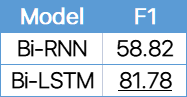

**Answer: (The test information for each model is shown in the output below)**

**The reason why Bi-RNN and Bi-LSTM are proposed is that both RNN and LSTM can only predict the output of the next moment based on the temporal information of the previous moment. In some cases, the output of the current moment is not only related to the previous state, but may also be related to the future state. Therefore, the model needs to have the ability to judge the context. Either Bi-LSTM or Bi-RNN can be considered as a two-layer neural network. The first layer is used as the starting input for the series from the left, while the second layer is used as the starting input for the series from the right. Finally the two results obtained are processed**

**The RNN model suffers from two very obvious technical flaws, namely gradient disappearance and gradient explosion. This is mainly attributed to the constant accumulation of gradients in backpropagation, which leads to the fact that RNNs are unable to learn long-term dependencies. The natural structure of the LSTM can overcome the problem of gradient disappearance. The main reason for this is that it performs not a matrix product calculation in backpropagation, but a product calculation of the corresponding elements, and does so based on a different gate value each time. Thus, the gradients of the memory units can be expected to propagate without gradient disappearance, which ensures that the LSTM is able to preserve (learn) long-term dependencies. Therefore, this is the reason why the Bi-LSTM performs even better in this experiment.**


In [ ]:
training_preprocessed_posts11 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts11 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts11 = training_preprocessed_posts11+testing_preprocessed_posts11

word_list11, word_dict11 = construct_wordlist_and_worddict(all_preprocessed_posts11)
training_posts_encoded11 = encode_and_add_padding(training_preprocessed_posts11, word_dict11)
testing_posts_encoded11 = encode_and_add_padding(testing_preprocessed_posts11, word_dict11)
from gensim.models import Word2Vec
wv_cbow_model11 = Word2Vec(sentences=all_preprocessed_posts11, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table11 = construct_trained_word_embedding(word_list11, wv_cbow_model11)
pretrained_emb_table11 = counstruct_pretrained_word_embedding(word_list11, model_type='gt_100')
emb_table_con11 = input_concatenation(trained_emb_table11, pretrained_emb_table11)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list11) 
emb_table = emb_table_con11
emb_dim = emb_table_con11.shape[-1
n_hidden = 16 

class Bi_RNN_Emb(nn.Module):
    def __init__(self):
        super(Bi_RNN_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.rnn = nn.RNN(emb_dim, n_hidden, batch_first =True, bidirectional=True) 
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        _, h_n= self.rnn(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded11), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_RNN_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>Bi-RNN with Word2vec (CBOW) + gt_100<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded11)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6953	Train_acc: 53.80%	
Epoch: 02 ->	Train_loss: 0.6680	Train_acc: 58.64%	
Epoch: 03 ->	Train_loss: 0.6490	Train_acc: 61.90%	
Epoch: 04 ->	Train_loss: 0.6348	Train_acc: 63.95%	
Epoch: 05 ->	Train_loss: 0.6158	Train_acc: 65.92%	
Epoch: 06 ->	Train_loss: 0.5982	Train_acc: 67.99%	
Epoch: 07 ->	Train_loss: 0.5843	Train_acc: 69.20%	
Epoch: 08 ->	Train_loss: 0.5657	Train_acc: 70.86%	
Epoch: 09 ->	Train_loss: 0.5523	Train_acc: 71.68%	
Epoch: 10 ->	Train_loss: 0.5352	Train_acc: 73.00%	
--------------------Training Finish---------------------

>>>Bi-RNN with Word2vec (CBOW) + gt_100<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.63      0.58      0.60       467
           T       0.55      0.60      0.57       400

    accuracy                           0.59       867
   macro avg       0.59      0.59      0.59       867
weigh

,Predicted Negative,Predicted Positive
Actual Negative,269,198
Actual Positive,159,241




---



In [ ]:
training_preprocessed_posts12 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts12 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts12 = training_preprocessed_posts12+testing_preprocessed_posts12

word_list12, word_dict12 = construct_wordlist_and_worddict(all_preprocessed_posts12)
training_posts_encoded12 = encode_and_add_padding(training_preprocessed_posts12, word_dict12)
testing_posts_encoded12 = encode_and_add_padding(testing_preprocessed_posts12, word_dict12)
from gensim.models import Word2Vec
wv_cbow_model12 = Word2Vec(sentences=all_preprocessed_posts12, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table12 = construct_trained_word_embedding(word_list12, wv_cbow_model12)
pretrained_emb_table12 = counstruct_pretrained_word_embedding(word_list12, model_type='gt_100')
emb_table_con12 = input_concatenation(trained_emb_table12, pretrained_emb_table12)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list12) 
emb_table = emb_table_con12
emb_dim = emb_table_con12.shape[-1
n_hidden = 16 

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

# Set hyperparameters
learning_rate = 0.005
batch_size = 256
total_epoch = 10

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded12), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

model = Bi_LSTM_Emb().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f'--------------------Training Begin---------------------')
for epoch in range(total_epoch):  
    loss_now = 0.0
    correct = 0

    for posts, targets in train_loader:
        posts_torch = posts.long().to(device)
        targets_torch = targets.long().to(device)

        temp_batch_size = posts_torch.shape[0] 

        model.train()
        optimizer.zero_grad()
        outputs = model(posts_torch)               
        loss = criterion(outputs, targets_torch)  
        loss.backward()       
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(outputs, -1) 
        correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\t" )
print(f'--------------------Training Finish---------------------')
print()
print(f'>>>Bi-LSTM with Word2vec (CBOW) + gt_100<<<')
print()
                                                                       
input_torch = torch.from_numpy(np.array(testing_posts_encoded12)).to(device)
model.eval()
outputs = model(input_torch) 
predicted = torch.argmax(outputs, -1)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = unique_labels.tolist()
print(f'-----------------Testing Information------------------')
print(classification_report(testing_labels_encoded, predicted.cpu().numpy(), target_names = target_names))
confusion_matrix(testing_labels_encoded, predicted.cpu().numpy())
pd.DataFrame(confusion_matrix(testing_labels_encoded, predicted.cpu().numpy()), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

--------------------Training Begin---------------------
Epoch: 01 ->	Train_loss: 0.6788	Train_acc: 57.25%	
Epoch: 02 ->	Train_loss: 0.5984	Train_acc: 67.74%	
Epoch: 03 ->	Train_loss: 0.5398	Train_acc: 72.98%	
Epoch: 04 ->	Train_loss: 0.5060	Train_acc: 75.24%	
Epoch: 05 ->	Train_loss: 0.4524	Train_acc: 79.12%	
Epoch: 06 ->	Train_loss: 0.3943	Train_acc: 83.07%	
Epoch: 07 ->	Train_loss: 0.3659	Train_acc: 84.12%	
Epoch: 08 ->	Train_loss: 0.3122	Train_acc: 87.21%	
Epoch: 09 ->	Train_loss: 0.2683	Train_acc: 89.52%	
Epoch: 10 ->	Train_loss: 0.2344	Train_acc: 90.56%	
--------------------Training Finish---------------------

>>>Bi-LSTM with Word2vec (CBOW) + gt_100<<<

-----------------Testing Information------------------
              precision    recall  f1-score   support

           F       0.83      0.83      0.83       467
           T       0.80      0.80      0.80       400

    accuracy                           0.82       867
   macro avg       0.82      0.82      0.82       867
weig

,Predicted Negative,Predicted Positive
Actual Negative,388,79
Actual Positive,79,321


## 4.5. HyperParameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.* Note that it will not be marked if you do not display it in the ipynb file.


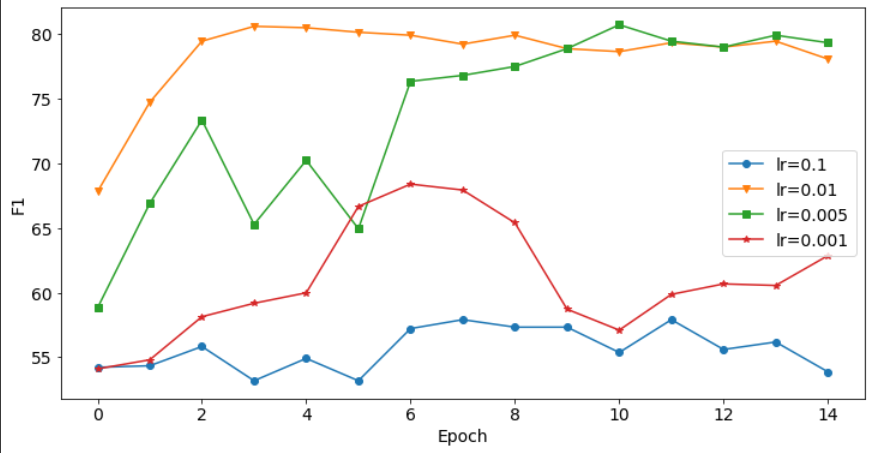

**Answer: (The test information for each model is shown in the output below)**


**Four different sizes of learning rates are selected for this hyperparametric comparison experiment, which aims to investigate the relationship between Epoch and F1-score.**

**Looking at the overall trend, both the blue line (lr=0.1) and the red line (lr=0.001) indicate the underfitting situation. As for the blue line, the parameters in the backpropagation do not converge well because the learning rate is too large. As for the red line, the exceedingly small learning rate causes the parameters to be updated so slowly that the increase in F1-score is insignificant.**

**The remaining two line also reflect over-fitting situation. As for orange lines(lr=0.01), it reachs maximun F1 score when epoch equals to 3. After that, it exhibits a level trend(fluctuates around 80). However, the accuracy of the training set continues to increase, which is a clear overfitting phenomenon. As for green line(lr=0.005), it reach maximun F1 score when epoch equals to 10, before which it keeps rising gradually. Although there is overfitting after this, it can be avoided by reducing the epoch. In general, setting the learning rate to 0.005 can have a better result and the epoch  can be set to 10 to avoid over-fitting.**

In [ ]:
training_preprocessed_posts13 = preprocess_data(training_posts, url=True, mode='lemm')
testing_preprocessed_posts13 = preprocess_data(testing_posts, url=True, mode='lemm')
all_preprocessed_posts13 = training_preprocessed_posts13+testing_preprocessed_posts13

word_list13, word_dict13 = construct_wordlist_and_worddict(all_preprocessed_posts13)
training_posts_encoded13 = encode_and_add_padding(training_preprocessed_posts13, word_dict13)
testing_posts_encoded13 = encode_and_add_padding(testing_preprocessed_posts13, word_dict13)
from gensim.models import Word2Vec
wv_cbow_model13 = Word2Vec(sentences=all_preprocessed_posts13, size=50, window=6, min_count=3, workers=2, sg=0)
trained_emb_table13 = construct_trained_word_embedding(word_list13, wv_cbow_model13)
pretrained_emb_table13 = counstruct_pretrained_word_embedding(word_list13, model_type='gt_100')
emb_table_con13 = input_concatenation(trained_emb_table13, pretrained_emb_table13)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Label Encoding
from sklearn.preprocessing import LabelEncoder
unique_labels = np.unique(training_labels)
lEnc = LabelEncoder()
training_labels_encoded = lEnc.fit_transform(training_labels)
testing_labels_encoded = lEnc.transform(testing_labels)
n_class = len(unique_labels)

vocab_size = len(word_list13) 
emb_table = emb_table_con13
emb_dim = emb_table_con13.shape[-1
n_hidden = 16 
# Set hyperparameters
batch_size = 256
total_epoch = 15

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader          
train_data = TensorDataset(torch.Tensor(training_posts_encoded13), torch.from_numpy(training_labels_encoded))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

learning_rates = [0.1, 0.01, 0.005, 0.001]
f1_recorder_1= [] #for 0.1
f1_recorder_2 = [] #for 0.01
f1_recorder_3 = [] #for 0.005
f1_recorder_4 = [] #for 0.001
for learning_rate in learning_rates:

    class Bi_LSTM_Emb(nn.Module):
        def __init__(self):
            super(Bi_LSTM_Emb, self).__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim)
            self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
            self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

            self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
            self.linear = nn.Linear(n_hidden*2, n_class)

        def forward(self, x):
            x = self.emb(x) # Get the embeded tensor
            lstm_out, (h_n, c_n) = self.lstm(x) 
            hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
            z = self.linear(hidden_out)
            return z
    
    print(f'-------------------------Learning rate: {learning_rate}--------------------------')
    model = Bi_LSTM_Emb().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(total_epoch):  
        loss_now = 0.0
        correct = 0

        for posts, targets in train_loader:
            posts_torch = posts.long().to(device)
            targets_torch = targets.long().to(device)

            temp_batch_size = posts_torch.shape[0] 

            model.train()
            optimizer.zero_grad()
            outputs = model(posts_torch)               
            loss = criterion(outputs, targets_torch)  
            loss.backward()       
            optimizer.step()

            loss_now += loss.item() * temp_batch_size
            predicted = torch.argmax(outputs, -1) 
            correct += accuracy_score(predicted.cpu().numpy(), targets.cpu().numpy())*temp_batch_size

        input_torch = torch.from_numpy(np.array(testing_posts_encoded13)).to(device)
        model.eval()
        outputs = model(input_torch) 
        predicted = torch.argmax(outputs, -1)
        f1 = f1_score(testing_labels_encoded, predicted.cpu().numpy(), average='micro')
        if learning_rate == learning_rates[0]:
            f1_recorder_1.append(f1)
        elif learning_rate == learning_rates[1]:
            f1_recorder_2.append(f1)
        elif learning_rate == learning_rates[2]:
            f1_recorder_3.append(f1)
        else:
            f1_recorder_4.append(f1)

        print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(loss_now/len(train_data)):.4f}\tTrain_acc: {(100*correct/len(train_data)):.2f}%\tF1: {(100*f1):.2f}%" )
    print()


-------------------------Learning rate: 0.1--------------------------
Epoch: 01 ->	Train_loss: 0.7136	Train_acc: 52.69%	F1: 54.21%
Epoch: 02 ->	Train_loss: 0.6728	Train_acc: 58.53%	F1: 54.33%
Epoch: 03 ->	Train_loss: 0.6539	Train_acc: 60.58%	F1: 55.82%
Epoch: 04 ->	Train_loss: 0.6468	Train_acc: 61.42%	F1: 53.17%
Epoch: 05 ->	Train_loss: 0.6318	Train_acc: 63.03%	F1: 54.90%
Epoch: 06 ->	Train_loss: 0.6257	Train_acc: 63.43%	F1: 53.17%
Epoch: 07 ->	Train_loss: 0.6065	Train_acc: 65.91%	F1: 57.21%
Epoch: 08 ->	Train_loss: 0.5859	Train_acc: 67.73%	F1: 57.90%
Epoch: 09 ->	Train_loss: 0.5745	Train_acc: 68.30%	F1: 57.32%
Epoch: 10 ->	Train_loss: 0.5702	Train_acc: 68.81%	F1: 57.32%
Epoch: 11 ->	Train_loss: 0.5693	Train_acc: 68.53%	F1: 55.36%
Epoch: 12 ->	Train_loss: 0.5540	Train_acc: 70.68%	F1: 57.90%
Epoch: 13 ->	Train_loss: 0.5394	Train_acc: 70.63%	F1: 55.59%
Epoch: 14 ->	Train_loss: 0.5450	Train_acc: 70.35%	F1: 56.17%
Epoch: 15 ->	Train_loss: 0.5317	Train_acc: 72.02%	F1: 53.86%

--------------

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
f1_1 = np.array(f1_recorder_1)
f1_1 = np.round(f1_1*100, 2)

f1_2 = np.array(f1_recorder_2)
f1_2 = np.round(f1_2*100, 2)

f1_3 = np.array(f1_recorder_3)
f1_3 = np.round(f1_3*100, 2)

f1_4 = np.array(f1_recorder_4)
f1_4 = np.round(f1_4*100, 2)

Epoch=range(15)
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size':14})
plt.plot(Epoch, f1_1, label = 'lr=0.1', marker='o')
plt.plot(Epoch, f1_2, label = 'lr=0.01', marker='v')
plt.plot(Epoch, f1_3, label = 'lr=0.005', marker='s')
plt.plot(Epoch, f1_4, label = 'lr=0.001', marker='*')

plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.show()

#5 - Test your model via Colab Form Fields User Interface

You are required to design a user interface so that user can input a textual sentence via the colab form fields user interface to get the personality type classification result from your trained model. *You can just modify based on the following Colab Form Fields template*

In [ ]:
#@title Personality Type Prediction
text = "I am thinking logically" #@param {type:"string"}
text = [text]

# Text Pre-processing
import re
def remove_urls(text):
    URLS_REGEX = re.compile(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', 
        re.IGNORECASE) #reference: https://stackoverflow.com/questions/4390556/extract-url-from-string
    text = re.sub(URLS_REGEX, '', text)
    return text

import numpy as np
import nltk
#Stopword
import string
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stopwords=sw.words('english')
#Tokenisation + Lowercase
from nltk.tokenize import TweetTokenizer #TweetTokenizer can retain Emoticons
tknzr = TweetTokenizer(preserve_case= False) #preserve_case= False->the tokenizer will downcase everything except for emoticons
#Stemming
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')
#Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def preprocess_data(text, url=True, mode=None):
    preprocessed_posts=[ ]
    for post in text :
        if url == True:
            post=remove_urls(post)
        remove_num = re.sub(r'[0-9]',' ', post) #Remove number
        remove_punc = re.sub(r'\.\.+|\||#|@', ' ', remove_num) #Remove a few common punctuations (to retain Emoticons in Tokenisation)
        clean_post = re.sub(r"\s+.\s", " ", remove_punc) #Remove signal characters
        tokenized_post = tknzr.tokenize(clean_post) #Tokenisation +Lowercase(except Emoticons)
        tokenized_post =  [w for w in tokenized_post if not w in stopwords and len(w)>1]
        if mode == 'stem':
            tokenized_post = [snowball_stemmer.stem(w) for w in tokenized_post]
        elif mode =='lemm':
            tokenized_post = [lemmatizer.lemmatize(w) for w in tokenized_post]
        else:
            tokenized_post = tokenized_post
        preprocessed_posts.append(tokenized_post)
    return preprocessed_posts

preprocessed_text = preprocess_data(text, url=True, mode='lemm')

# Load word dictionary and transfer encoding
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pickle
id = '1W8hm8k7Dbz1ZGb4Ohymj6jE1QtZ_N1Sg'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_dict.pkl')
with open('word_dict.pkl','rb') as f: 
    word_dict = pickle.load(f)

def encode_and_add_padding(posts, word_index):
    post_encoded = []
    post_length = 600
    for post in posts:
        if not len(post) > post_length:
            temp_encoded = [word_index[word] if word in word_index  
                            else word_index['[UNKNOWN]'] 
                            for word in post] 
            if len(temp_encoded) < post_length: 
                temp_encoded += [word_index['[PAD]']] * (post_length - len(temp_encoded))
        else:
            post = post[ :post_length]
            temp_encoded = [word_index[word] if word in word_index
                            else word_index['[UNKNOWN]'] 
                            for word in post]
        post_encoded.append(temp_encoded)
    return post_encoded 

text_encoded = encode_and_add_padding(preprocessed_text, word_dict)

# Define model class and load pre-trained model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table)) # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.requires_grad = False  # Optional: set requires_grad = False to make this lookup table untrainable

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor
        lstm_out, (h_n, c_n) = self.lstm(x) 
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z

id = '1N6WLKxM9xANi1RtcD6YePSlPkOh8AtFE'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('best_model.pt')
best_model = torch.load('best_model.pt')

text_torch = torch.from_numpy(np.array(text_encoded)).to(device)
best_model.eval()
outputs = best_model(text_torch) 
predicted = torch.argmax(outputs, -1)

print()
if predicted ==0:
    print(f'Predicted Personality Type: F')
else:
    print(f'Predicted Personality Type: T')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Predicted Personality Type: T
